### Домашнее задание "Функции потерь и оптимизация"

In [1]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [3]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [4]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt


def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])


    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

### LogisticRegression

In [5]:
class LogisticRegression(object):
    
    def __init__(self, eta=0.05, n_iter=10, random_state=1):
  
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
            
    def fit(self, X, y):
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = np.dot(X, self.w_[1:]) + self.w_[0]
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
        return self    
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

### Nesterov accelerated gradient

In [6]:
class Nesterov(object):
    
    def __init__(self, eta=0.05, n_iter=10, random_state=1, gamma=0.9):
 
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.gamma = gamma

    def fit(self, X, y):
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        self.exponential_running_average = []
        v = 0

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            v = self.gamma*v + self.eta * X.T.dot(errors)
            self.w_[1:] -= v
            self.w_[0] += self.eta * errors.sum()
            
            np.seterr(divide = 'ignore')
            
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
            self.exponential_running_average.append(v)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

### Adagrad

In [7]:
class Adagrad(object):
    
    def __init__(self, eta=0.05, eps=10**-8, n_iter=10, random_state=1):
        
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.eps = eps

    def fit(self, X, y):
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        self.G = []
        G = 0
        

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            G += np.square(self.eta * X.T.dot(errors))
            
            self.w_[1:] -= (self.eta/np.sqrt(G + self.eps))*(self.eta * X.T.dot(errors))
            self.w_[0] += self.eta * errors.sum()
            
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
            self.G.append(G)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

### RMSProp

In [8]:
class RMSProp(object):
    
    def __init__(self, eta=0.05, eps=10**-8, n_iter=10, random_state=1, gamma=0.9):
        
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.eps = eps
        self.gamma = gamma

    def fit(self, X, y):
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        EG = 0

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            
            EG += self.gamma*EG + (1-self.gamma)*np.square(self.eta * X.T.dot(errors))
            
            self.w_[1:] -= (self.eta/np.sqrt(EG + self.eps))*(self.eta * X.T.dot(errors))
            self.w_[0] += self.eta * errors.sum()
            
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            self.cost_.append(cost)
            
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

### LogisticRegression

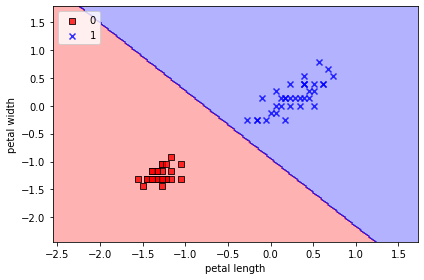

In [9]:
X_train_lr = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_lr = y_train[(y_train == 0) | (y_train == 1)]

lr = LogisticRegression(eta=0.1, n_iter=6, random_state=1)
lr.fit(X_train_lr,
         y_train_lr)

plot_decision_regions(X_train_lr, 
                      y_train_lr,
                      classifier=lr)

plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Nesterov accelerated gradient

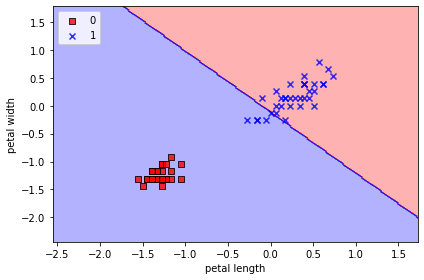

In [13]:
X_train_NAG = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_NAG = y_train[(y_train == 0) | (y_train == 1)]

NAG = Nesterov(eta=0.1, n_iter=3, random_state=1,  gamma=0.2)
NAG.fit(X_train_NAG,
         y_train_NAG)

plot_decision_regions(X_train_NAG, 
                      y_train_NAG,
                      classifier=NAG)

plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### Adagrad

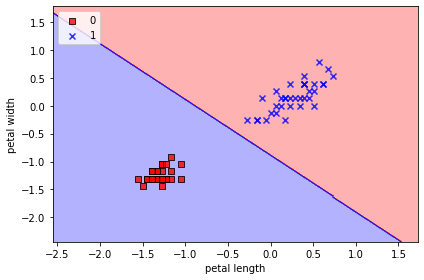

In [11]:
X_train_Adagrad = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_Adagrad = y_train[(y_train == 0) | (y_train == 1)]

AD = Adagrad(eta=0.05, eps=10**-6, n_iter=5, random_state=1)
AD.fit(X_train_Adagrad,y_train_Adagrad)

plot_decision_regions(X_train_Adagrad, 
                      y_train_Adagrad,
                      classifier=AD)

plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

### RMSProp

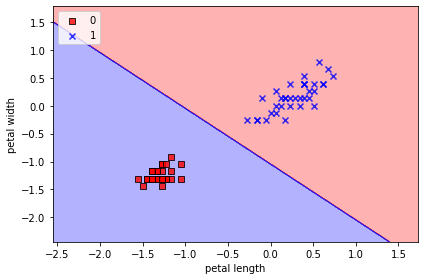

In [12]:
X_train_RMSProp = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_RMSProp = y_train[(y_train == 0) | (y_train == 1)]

RMSProp_ = RMSProp(eta=0.05, eps=10**-6, n_iter=10, random_state=1, gamma=0.9)
RMSProp_.fit(X_train_RMSProp,
         y_train_RMSProp)

plot_decision_regions(X_train_RMSProp, 
                      y_train_RMSProp,
                      classifier=RMSProp_)

plt.xlabel('petal length')
plt.ylabel('petal width')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()